# Scanning over several parameters for K16 to investigate when transits stop occuring. Conclusion is that transits stop rapidly for any serious variation in any inclination parameter, and that if Wp is not near zero, transits become very patchy.

In [50]:
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as p
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Kepler 16
cb = funcs.CBSystem(m1 = 0.6897,f1 = 1.,m2 = 0.20255,f2 = 0.01555,
                    ab = 0.22431,r1 = 0.6489 * u.Rsun.to('au'),r2 = 0.22623 * u.Rsun.to('au'),
                    eb = 0.15944,ib = np.deg2rad(90.3401),wb = np.deg2rad(263.464),
                    fb = np.deg2rad(186.53239),
                    mp = .03e-3,ap = 0.7048,rp = 0.7538 * u.Rjupiter.to('au'),ep = 0.0069,
                    ip = np.deg2rad(90.0322),wp = np.deg2rad(318.0),fp = np.deg2rad(148.92),
                    Wp = np.deg2rad(0.003),
                    t0 = 2455212.12316)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days

print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi

41.0790034492
228.79461019691053


In [41]:
#scan over a range of parameters and track transit times and durations through each.
#not very informative - can't get the resolution to see changes gradually, without excessive run time.
#only output is that which transits appear is very sensitive to everything...
#p_p : hold
mratset = np.linspace(0.1,1,10)
mtotset = np.linspace(1,3,3)
ibset = np.deg2rad(np.linspace(89.7,90.3,10))
#hold eb
#hold wb
#hold fb
#fp+wp: hold
#ep: hold at 0 - even on K34 - the ep was barely detected when fitting against the transit times
#wp: hold
ipset = np.deg2rad(np.linspace(89.5,90.5,20))
Wpset = np.linspace(0,2*np.pi,10)
#hold t0


dt = 0.02
t = np.arange(2454953,2456424,dt)

ipset

array([ 1.56206968,  1.56298827,  1.56390687,  1.56482546,  1.56574406,
        1.56666265,  1.56758125,  1.56849984,  1.56941844,  1.57033703,
        1.57125562,  1.57217422,  1.57309281,  1.57401141,  1.57493   ,
        1.5758486 ,  1.57676719,  1.57768578,  1.57860438,  1.57952297])

In [8]:
%timeit funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
#%timeit funcs.pd_cb(cb, times=t)
%timeit funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), tmax=np.max(t), timing_precision=timing_precision)


87.1 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.9 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
tts_all = {}
tds_all = {}

#horrible for loop filling in a 7 fold dict of dicts
for mrat in mratset:
    print(mrat)
    if mrat not in tts_all.keys():
        tts_all[mrat] = {}
        tds_all[mrat] = {}
        
    for mtot in mtotset:
        cb.m2 = mtot / (1 + 1./mrat)
        cb.m1 = mtot / (1 + mrat)
        if mtot not in tts_all[mrat].keys():
            tts_all[mrat][mtot] = {}
            tds_all[mrat][mtot] = {}
            
        for ib in ibset:
            cb.ib = ib
            if ib not in tts_all[mrat][mtot].keys():
                tts_all[mrat][mtot][str(ib)[:6]] = {}
                tds_all[mrat][mtot][str(ib)[:6]] = {}  
                
            for ip in ipset:
                cb.ip = ip
                if ip not in tts_all[mrat][mtot][str(ib)[:6]].keys():
                    tts_all[mrat][mtot][str(ib)[:6]][str(ip)[:6]] = {}
                    tds_all[mrat][mtot][str(ib)[:6]][str(ip)[:6]] = {}  
                            
                for Wp in Wpset:
                    cb.Wp = Wp
                                
                    ttimes, tdurs = funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), 
                                        tmax=np.max(t), timing_precision=timing_precision)
                            
                    tts_all[mrat][mtot][str(ib)[:6]][str(ip)[:6]][str(Wp)[:6]] = ttimes[tdurs>0] - cb.t0
                    tds_all[mrat][mtot][str(ib)[:6]][str(ip)[:6]][str(Wp)[:6]] = tdurs[tdurs>0]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [56]:
tts_all.keys()

dict_keys([0.10000000000000001, 0.20000000000000001, 0.30000000000000004, 0.40000000000000002, 0.5, 0.59999999999999998, 0.70000000000000007, 0.80000000000000004, 0.90000000000000002, 1.0])

<IPython.core.display.Javascript object>


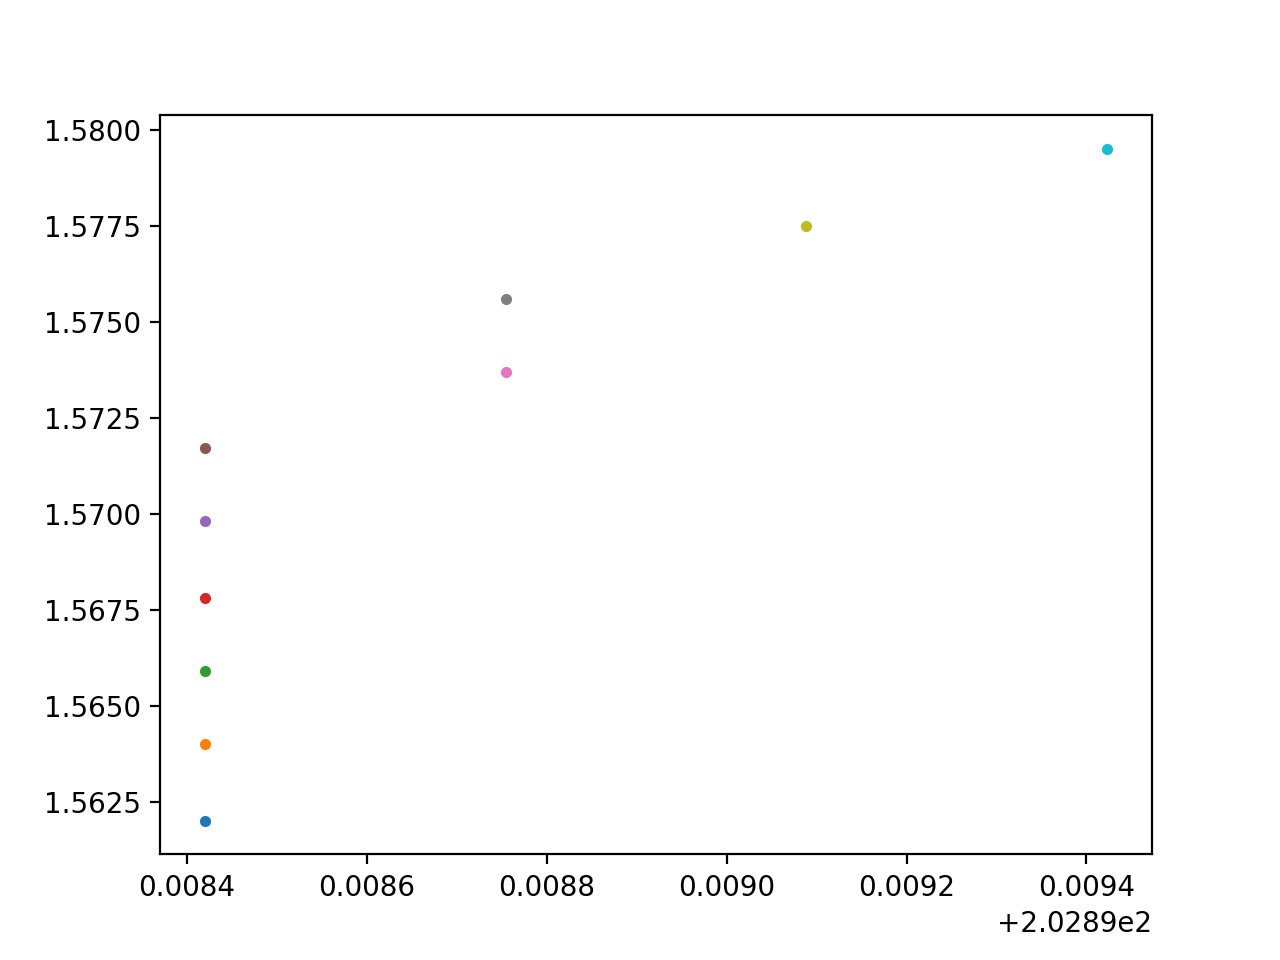

<IPython.core.display.Javascript object>


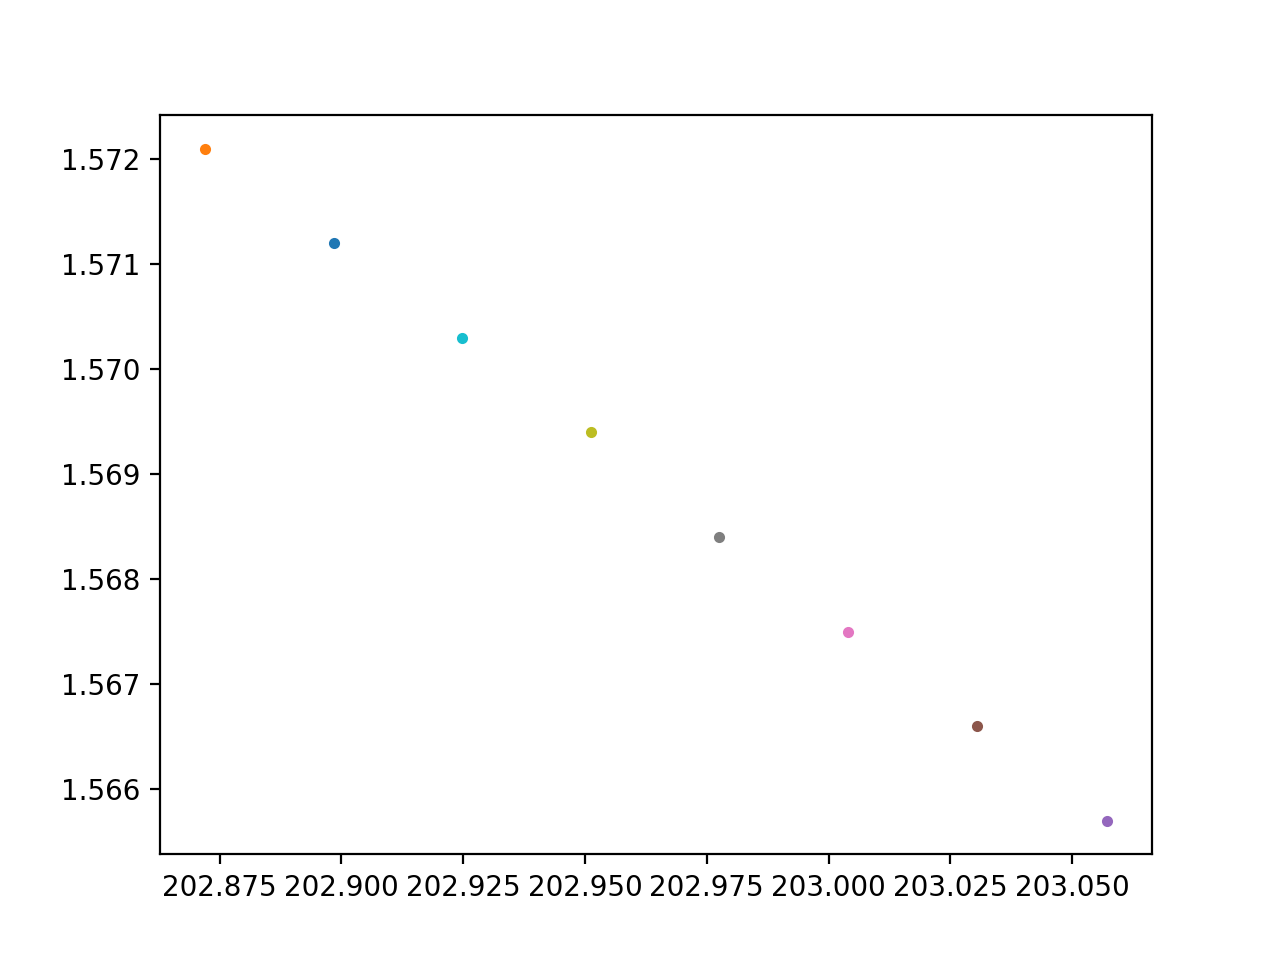

<IPython.core.display.Javascript object>


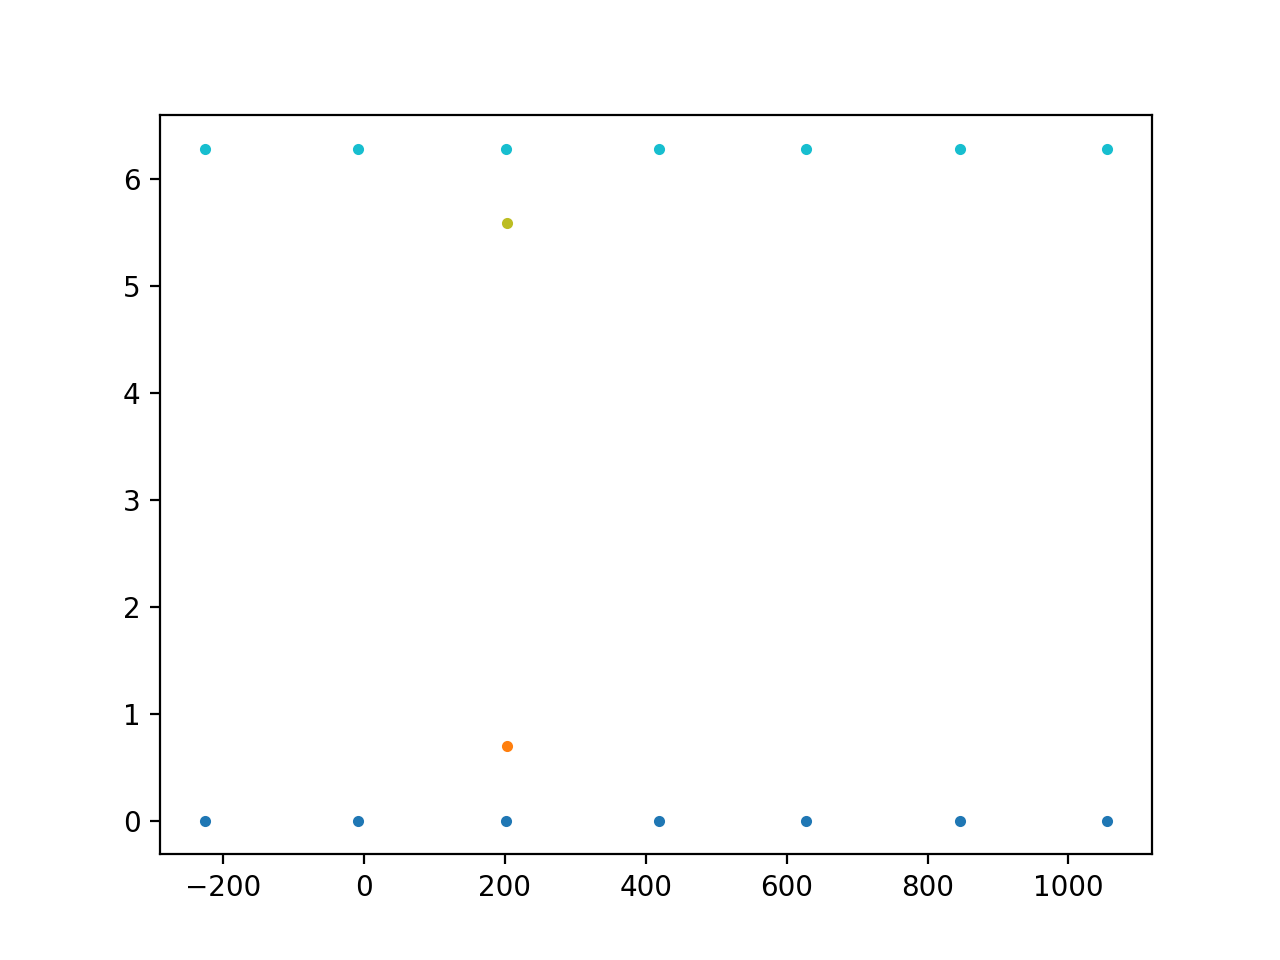

In [57]:
#plot transit times descending as function of another parameter

mrat_fix = 0.30000000000000004
mtot_fix = 1.0
ib_fix = '1.5698'
ip_fix = '1.5712'
wp_fix = '5.5850'

#ib
ibtimes = []
ibs = tts_all[mrat_fix][mtot_fix].keys()

for ib in ibs:
    ibtimes.append(tts_all[mrat_fix][mtot_fix][ib][ip_fix][wp_fix])

p.figure()
for ib,timearray in zip(ibs,ibtimes):
    p.plot(timearray,float(ib)*np.ones(len(timearray)),'.')
  
#ip (for a given wp)

iptimes = []
ips = tts_all[mrat_fix][mtot_fix][ib_fix].keys()

for ip in ips:
    iptimes.append(tts_all[mrat_fix][mtot_fix][ib_fix][ip][wp_fix])

p.figure()
for ip,timearray in zip(ips,iptimes):
    p.plot(timearray,float(ip)*np.ones(len(timearray)),'.')
    
#wp (for a given ip)

wptimes = []
wps = tts_all[mrat_fix][mtot_fix][ib_fix][ip_fix].keys()

for wp in wps:
    wptimes.append(tts_all[mrat_fix][mtot_fix][ib_fix][ip_fix][wp])

p.figure()
for wp,timearray in zip(wps,wptimes):
    p.plot(timearray,float(wp)*np.ones(len(timearray)),'.')
    


In [60]:
#detailed scan of some parameters: 
#mratset = np.linspace(0.1,1,10)
#mtotset = np.linspace(1,3,3)
ibset = np.deg2rad(np.linspace(89.7,90.3,100))
#hold eb
#hold wb
#hold fb
#fp+wp: hold
#ep: hold at 0 - even on K34 - the ep was barely detected when fitting against the transit times
#wp: hold
ipset = np.deg2rad(np.linspace(89.5,90.5,10))
Wpset = np.linspace(0,2*np.pi,10)
#hold t0


dt = 0.02
t = np.arange(2454953,2456424,dt)


In [61]:
tts_all = {}
tds_all = {}

#horrible for loop filling in a 7 fold dict of dicts

for ib in ibset:
    cb.ib = ib
    if ib not in tts_all.keys():
        tts_all[str(ib)[:6]] = {}
        tds_all[str(ib)[:6]] = {}  
                
    for ip in ipset:
        cb.ip = ip
        if ip not in tts_all[str(ib)[:6]].keys():
            tts_all[str(ib)[:6]][str(ip)[:6]] = {}
            tds_all[str(ib)[:6]][str(ip)[:6]] = {}  
                            
        for Wp in Wpset:
            cb.Wp = Wp
                                
            ttimes, tdurs = funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), 
                                        tmax=np.max(t), timing_precision=timing_precision)
                            
            tts_all[str(ib)[:6]][str(ip)[:6]][str(Wp)[:6]] = ttimes[tdurs>0] - cb.t0
            tds_all[str(ib)[:6]][str(ip)[:6]][str(Wp)[:6]] = tdurs[tdurs>0]

In [69]:
tts_all['1.5707']['1.5698'].keys()

dict_keys(['0.0', '0.6981', '1.3962', '2.0943', '2.7925', '3.4906', '4.1887', '4.8869', '5.5850', '6.2831'])

<IPython.core.display.Javascript object>


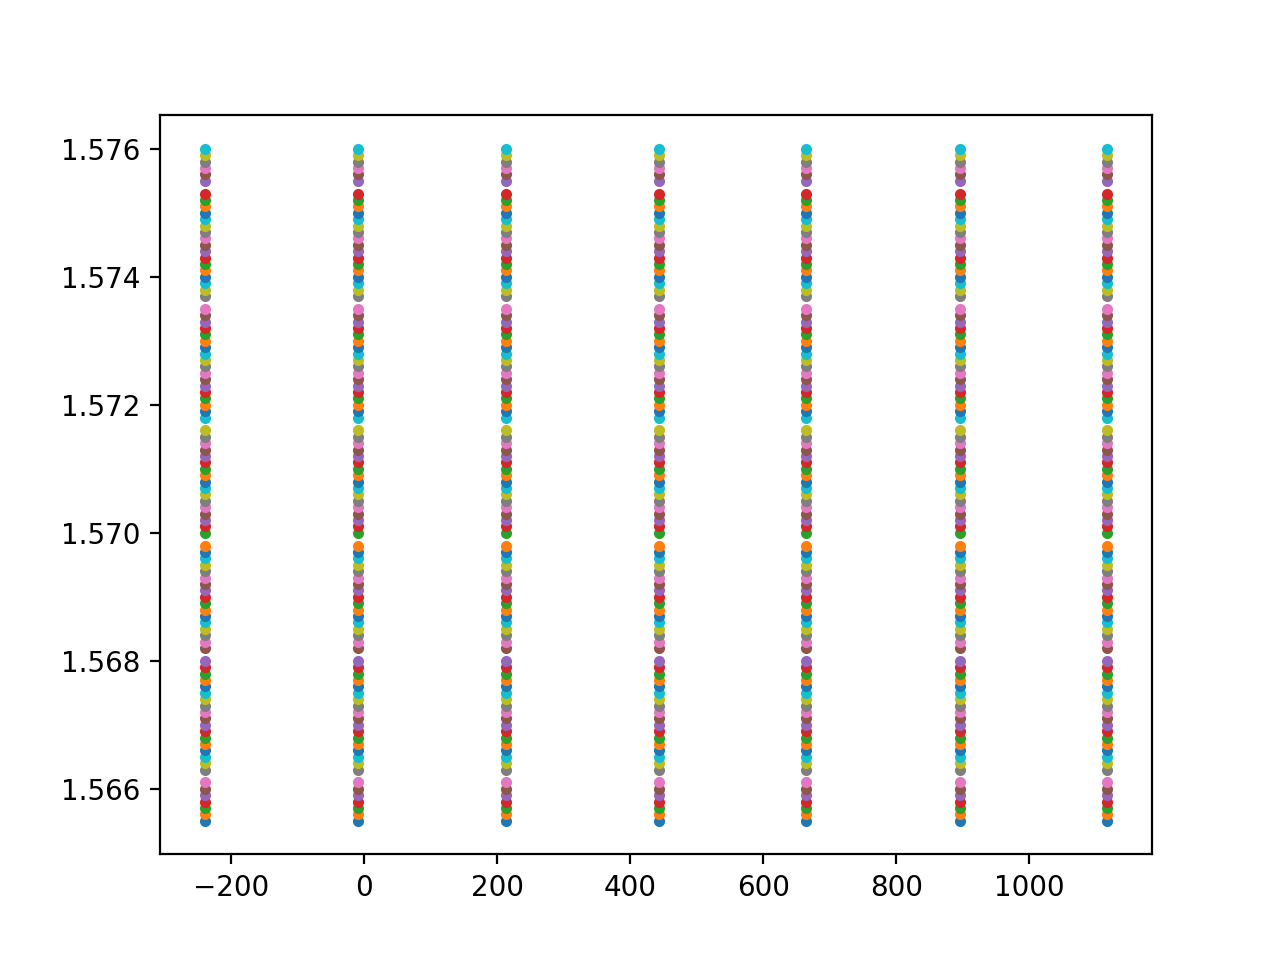

<IPython.core.display.Javascript object>


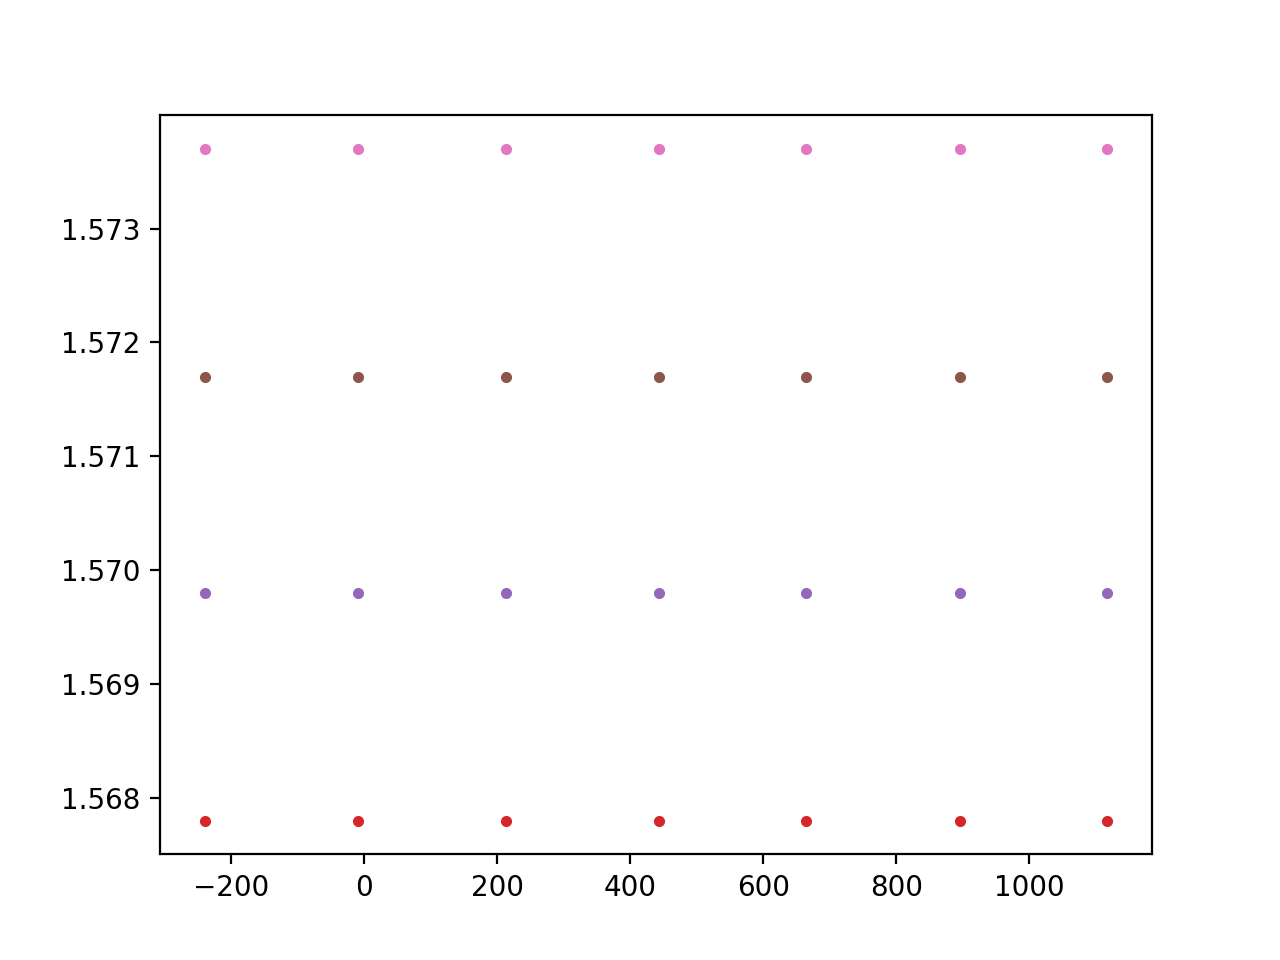

<IPython.core.display.Javascript object>


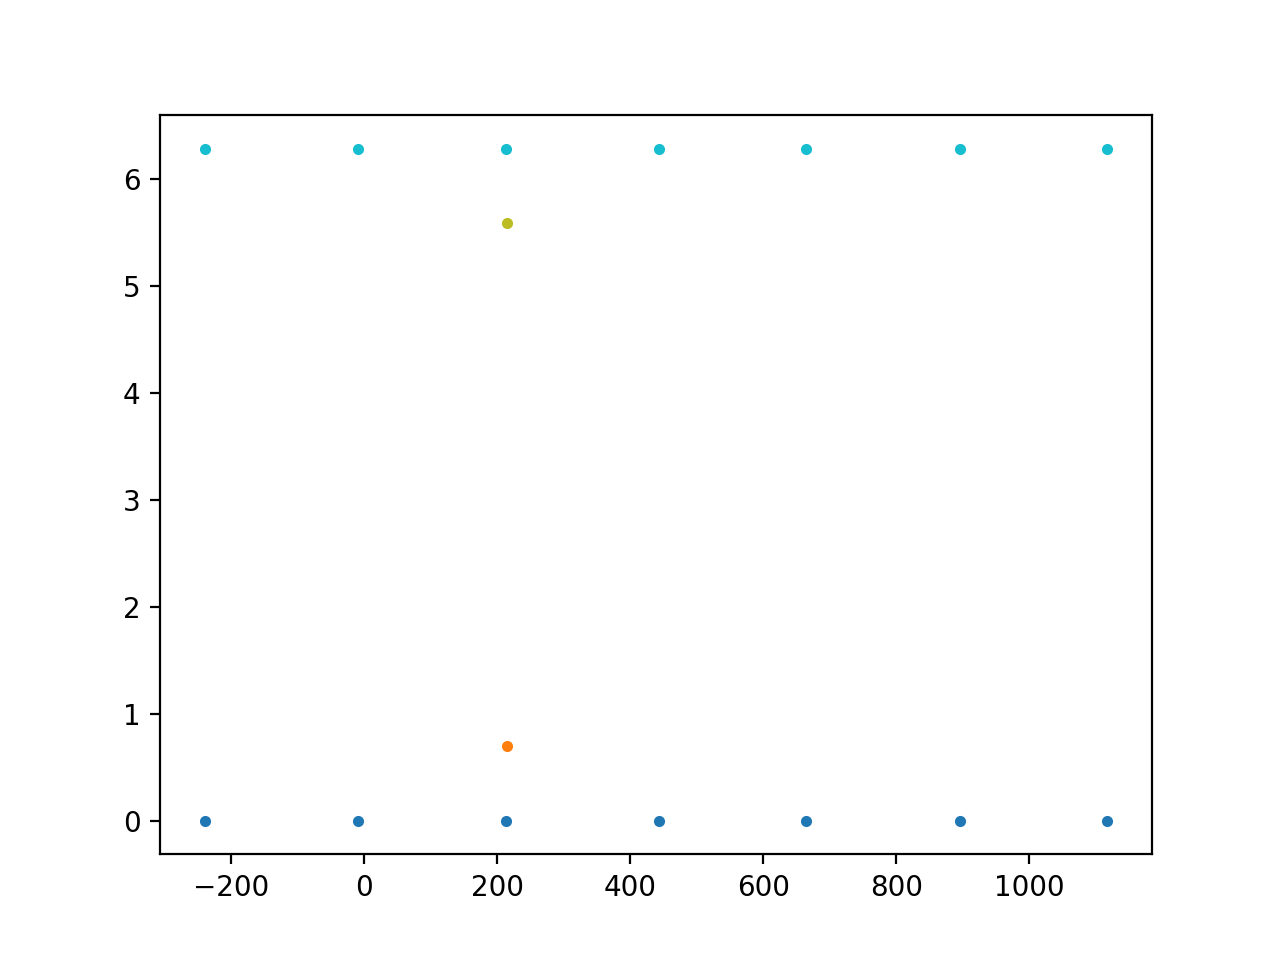

In [71]:

ib_fix = '1.5707'
ip_fix = '1.5698'
Wp_fix = '0.0'

#ib
ibtimes = []
ibs = tts_all.keys()

for ib in ibs:
    ibtimes.append(tts_all[ib][ip_fix][Wp_fix])

p.figure()
for ib,timearray in zip(ibs,ibtimes):
    p.plot(timearray,float(ib)*np.ones(len(timearray)),'.')
  
#ip (for a given wp)

iptimes = []
ips = tts_all[ib_fix].keys()

for ip in ips:
    iptimes.append(tts_all[ib_fix][ip][Wp_fix])

p.figure()
for ip,timearray in zip(ips,iptimes):
    p.plot(timearray,float(ip)*np.ones(len(timearray)),'.')
    
#Wp (for a given ip)

Wptimes = []
Wps = tts_all[ib_fix][ip_fix].keys()

for Wp in Wps:
    Wptimes.append(tts_all[ib_fix][ip_fix][Wp])

p.figure()
for Wp,timearray in zip(Wps,Wptimes):
    p.plot(timearray,float(Wp)*np.ones(len(timearray)),'.')
    
